In [ ]:
# !pip3 install tensorflow-ranking
# !pip3 install tensorflow
# !pip3 install numpy
# !pip3 install pickle
# !pip3 install math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports and Dirs

In [ ]:


import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as tfback
from tensorflow.keras import layers, activations, Model, losses
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import os
import pickle
import math


In [ ]:
"""
#uncomment if running as .py on cluster such as HIPPO
#comment if running as .ipynb on Google Colab


import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str)
parser.add_argument('--input_data', type=str)
parser.add_argument('--training_results', type=str, default="vae_ml10m_training_results")

parser.add_argument('--prim_pel', type=str, default="prim_pel.txt")
parser.add_argument('--prim_pbl', type=str, default="prim_pbl.txt")
parser.add_argument('--prim_pevl', type=str, default="prim_pevl.txt")

parser.add_argument('--sec_pel', type=str, default="sec_pel.txt")
parser.add_argument('--sec_pbl', type=str, default="sec_pbl.txt")
parser.add_argument('--sec_pevl', type=str, default="sec_pevl.txt")


parser.add_argument('--weights', type=str)
parser.add_argument('--intermediatedim', type=int, default=512)
parser.add_argument('--epochs', type=int, default=30)
parser.add_argument('--batchsize', type=int, default=500)
parser.add_argument('--klannealrate', type=float, default=0.001)
args = parser.parse_args()
"""

In [ ]:
#uncomment if running as .ipynb on Google Colabas
#comment if running as  .py on cluster such as HIPPO
class argclass(object):
  def __init__(self):
    self.root = "/content/drive/MyDrive/COMP700_Honours Project"
    self.input_data = "Data/movielens_10m/"
    self.training_results ="vae_ml10m_training_results"

    self.prim_pel = "prim_pel.txt"        #primary training, per-epoch loss
    self.prim_pbl = "prim_pbl.txt"        #primary training, per-batch loss
    self.prim_pevl = "prim_pevl.txt"      #primary training, per-epoch validation loss

    self.sec_pel = "sec_pel.txt"        #secondary training, per-epoch loss
    self.sec_pbl = "sec_pbl.txt"        #secondary training, per-batch loss
    self.sec_pevl = "sec_pevl.txt"      #secondary training, per-epoch validation loss

    self.weights = "vae_primary_train_best.hdf5"
    self.intermediatedim = 512 
    self.epochs = 30
    self.batchsize = 500
    self.klannealrate = 0.001
args = argclass()

In [ ]:
root = args.root

input_data = args.input_data
input_data = os.path.join(root, input_data, "split/matrices/implicit")

training_results = args.training_results
training_results = os.path.join(root, training_results)



try:
  os.mkdir(training_results)
except FileExistsError:
  pass

#IF NO WEIGHTS FILE TO USE, THEN JUST LEAVE ARG OUT. THE LAOD FUNCTION WILL KNOW TO START ANEW
# Checkpoint callback saves into filepath=os.path.join(training_results,"vae_epoch_{epoch:02d}_loss_{loss:.2f}.hdf5")
weights = args.weights
try:
  weights = os.path.join(training_results, weights)
except TypeError:
  pass

#annealing_rate = args.klannealrate
#intermediate_dim = args.intermediatedim
#total_num_epochs = args.epochs
#batch_size = args.batchsize



print(root)
print(input_data)
print(training_results)
print(weights)

/content/drive/MyDrive/COMP700_Honours Project
/content/drive/MyDrive/COMP700_Honours Project/Data/movielens/split/matrices/implicit
/content/drive/MyDrive/COMP700_Honours Project/vae_ml10m_training_results
/content/drive/MyDrive/COMP700_Honours Project/vae_ml10m_training_results/vae_primary_train_best.hdf5


#Model design
* sample layer
* batch history callback
* vae loss function
* VAE builder class
* data generator sequence

In [ ]:
class Sampling(layers.Layer):
  def __init__(self, name="Sampling", **kwargs):
    super(Sampling, self).__init__(name=name, **kwargs)
    
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]


    #epsilon = distribution.sample()
    
    epsilon = tfback.random_normal(shape=(batch,dim))
    sample = epsilon * tf.exp(0.5 * z_log_var)  +   z_mean  #Reparametrization trick: convert from standard normal to desired distribution

    return sample

In [ ]:
class BatchHistory(keras.callbacks.Callback):  
  def __init__(self, pel, pbl, pevl):
    super(BatchHistory,self).__init__() 
    self.loss = [] 
    self.val_loss = 0.0
    self.pel = pel
    self.pbl = pbl
    self.pevl = pevl

  def on_train_batch_end(self, batch, logs=None):   
    self.loss.append(logs.get('loss'))


  def on_epoch_end(self, epoch, logs=None):
    self.val_loss = logs.get('val_loss')
    self.loss = [str(i) for i in self.loss]

    with open(os.path.join(training_results,self.pevl), "a") as pe_v_loss:
      pe_v_loss.write('\n'+ str(self.val_loss))

    with open(os.path.join(training_results,self.pbl), "a") as pb_loss:
      pb_loss.write("\n")
      pb_loss.writelines('\n'.join(self.loss))

    with open(os.path.join(training_results,self.pel), "a") as pe_loss:
      pe_loss.write('\n'+ str(self.loss[len(self.loss)-1]))
    self.loss = []
    

In [ ]:
#original_dim = 127350
annealing_rate = args.klannealrate
#KLBeta = 1 # initialised to relevant values(0 for prim, 1 for sec) immediately before each training section
def VAE_loss(y_true, y_pred):
    global KLBeta
    reconst_loss =  original_dim * losses.binary_crossentropy(y_true, y_pred)
    KLDiv = KLBeta * losses.kl_divergence(y_true, y_pred)

    KLBeta = min(KLBeta+annealing_rate , 1) #update weight of KL factor

    #return (KLDiv,reconst_loss)

    return  reconst_loss + KLDiv


In [ ]:
class vae_builder(object):
  def __init__(self, original_dim, intermediate_dim, latent_dim, name='VAE'):
    self.name = name
    self.original_dim = original_dim
    self.intermediate_dim = intermediate_dim
    self.latent_dim = latent_dim

  
  def build(self):
    self.input = layers.Input(self.original_dim, name = 'input')
    #self.dropout = layers.Dropout(rate=0.5)(self.input)

    #encoder
    self.d1 = layers.Dense(self.intermediate_dim, activation='tanh', name = 'encoder_dense_1')(self.input)
    self.n1 = layers.LayerNormalization(name = 'encoder_layernorm_1')(self.d1)

    self.d2 = layers.Dense(self.intermediate_dim, activation='tanh', name = 'encoder_dense_2')(self.n1)
    self.n2 = layers.LayerNormalization(name = 'encoder_layernorm_2')(self.d2)

    self.d3 = layers.Dense(self.intermediate_dim, activation='tanh', name = 'encoder_dense_3')(self.n2)
    self.n3 = layers.LayerNormalization(name = 'encoder_layernorm_3')(self.d3)

    self.d4 = layers.Dense(self.intermediate_dim, activation='tanh', name = 'encoder_dense_4')(self.n3)
    self.n4 = layers.LayerNormalization(name = 'encoder_layernorm_4')(self.d4)

    self.d5 = layers.Dense(self.intermediate_dim, activation='tanh', name = 'encoder_dense_5')(self.n4)
    self.n5 = layers.LayerNormalization(name = 'encoder_layernorm_5')(self.d5)

    #sampling
    self.mean = layers.Dense(self.latent_dim, name = 'mean')(self.n5)  
    self.log_var = layers.Dense(self.latent_dim, name = 'log_var')(self.n5)  
    self.sampling = Sampling()([self.mean, self.log_var])

    #decoder
    self.d1 = layers.Dense(self.intermediate_dim, activation='relu',name = 'decoder_dense_1')(self.sampling)
    self.d2 = layers.Dense(self.original_dim, activation='relu', name = 'decoder_dense_2')(self.d1)  
    
    self.output = layers.Activation(activations.swish, name = 'output')(self.d2)

    #to model
    vae = Model(inputs = self.input, outputs = self.output, name = self.name)
    return vae

In [ ]:
class datagen(keras.utils.Sequence):
  def __init__(self, x_set, y_set, batch_size=500, max_samples_per_epoch=None):
    self.x = x_set
    self.y = y_set
  
    self.batch_size = batch_size

    self.shuffled_idx = np.arange(np.shape(self.x)[0]) #get indexes
    np.random.shuffle(self.shuffled_idx) # shuffle

    if max_samples_per_epoch is not None:
      self.shuffled_idx = self.shuffled_idx[:max_samples_per_epoch] #cutoff at max no of samples allowed in epoch

  def on_epoch_end(self):
    self.shuffled_idx = np.arange(np.shape(self.x)[0]) #get indexes
    np.random.shuffle(self.shuffled_idx) # shuffle
    if max_samples_per_epoch is not None:
      self.shuffled_idx = self.shuffled_idx[:max_samples_per_epoch] #cutoff at max no of samples allowed in epoch

  def __len__(self):
      return math.ceil((self.shuffled_idx.shape[0]) / self.batch_size)
      
  def __getitem__(self, idx):

    b_idx = idx * self.batch_size
    e_idx = (idx + 1) * self.batch_size

    idx = self.shuffled_idx[b_idx:e_idx] #cut slice of indexes using begin and end indexes

    batch_x = np.array(self.x[idx].todense())
    batch_y = np.array(self.y[idx].todense())


    return batch_x , batch_y


#TRAINING

In [ ]:
intermediate_dim = args.intermediatedim
latent_dim = intermediate_dim//2 #64

total_num_epochs = args.epochs

batch_size = args.batchsize

###code to allow continuation of training over many sessions

In [ ]:
def load_model(v, weights_file):
  try:
    v.load_weights(weights_file)
    print("weights loaded successfully")
  except:
    print("failed to load weights")

def get_num_epochs_complete():
  try:
    with open(os.path.join(training_results,args.prim_pevl), "r") as f:
      lines = [i for i in f.readlines() if len(i.strip()) > 0]
      return len(lines)
  except FileNotFoundError:
    return 0

##Primary Train


###load data and set params

In [ ]:
train = pickle.load( 
    open(os.path.join(input_data,"train_impl.pkl") , 'rb')
)
vad = pickle.load( 
    open(os.path.join(input_data,"vad_impl.pkl") , 'rb')
)

In [ ]:
total_num_samples = train.shape[0]
original_dim = train.shape[1]

In [ ]:
train_gen = datagen(train,train , batch_size)
vad_gen = datagen(vad,vad,  batch_size)
train_gen.__len__()

100

In [ ]:
a = train_gen.__getitem__(0)[0][0]
b = np.nonzero(a)[0]
print(b)

print(a[b])

[   83   831  1633  1676  1895  2070  2117  2492  2621  2630  2691  2789
  2835  2872  2886  3018  3779  4103  4114  4647  4725  5127  5562  6388
  6815  7131  7341  7469  7473  8100  8239  8240  8751  8885  9098  9443
  9461  9463  9673 10398 10495 10608 10678 10983 11056 11243 11312 11804
 12121 12272 12583 12705 13110 13136 13709 14841 14884 14937 14954 15133
 15174 15400 15845 15851 16083 16483 16932 17613 17664 17710 17711]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


###Train code block


In [ ]:
#REFRESH CALLBACKS BEFORE EACH RUN
#or else separate runs in same session will behave oddly
KLBeta = 0
checkpoint = ModelCheckpoint(filepath=os.path.join(training_results,"vae_primary_train_best.hdf5"), verbose=1, save_best_only=True)
batch_hist = BatchHistory(args.prim_pel, args.prim_pbl, args.prim_pevl) #use primary train loss logs
reduce_LR = ReduceLROnPlateau(patience=10,verbose=1, factor=0.5)
#BUILD STRUCTURE
v = vae_builder(original_dim, intermediate_dim, latent_dim).build()

v.compile(optimizer='adam', loss=VAE_loss)

#PICK UP FROM WHERE LAST LEFT OFF
complete_epochs = get_num_epochs_complete()
remaining_epochs = total_num_epochs - complete_epochs
load_model(v, weights)

#RUN
print("commisioned to run for",total_num_epochs,"epochs total")
print("known loss values found for ",complete_epochs,"previous epochs")
print("will run for", remaining_epochs, "more epochs unless stopped early")

v.fit(train_gen, verbose=True, epochs=remaining_epochs, validation_data=vad_gen, callbacks=[checkpoint,batch_hist, reduce_LR])

print("complete")


keras.utils.plot_model(v, show_layer_activations=True)
v.save_weights(os.path.join(training_results,"vae_primary_train_last.hdf5"))

failed to load weights
commisioned to run for 30 epochs total
known loss values found for  0 previous epochs
will run for 30 more epochs unless stopped early
Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 1095.0676
Epoch 00001: val_loss improved from inf to 1002.87231, saving model to /content/drive/MyDrive/COMP700_Honours Project/vae_ml10m_training_results/vae_primary_train_best.hdf5
100/100 [==============================] - 10s 86ms/step - loss: 1095.0676 - val_loss: 1002.8723 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 929.0750
Epoch 00002: val_loss improved from 1002.87231 to 916.62769, saving model to /content/drive/MyDrive/COMP700_Honours Project/vae_ml10m_training_results/vae_primary_train_best.hdf5
100/100 [==============================] - 11s 106ms/step - loss: 929.0750 - val_loss: 916.6277 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 897.6243
Epoch 00003: val_loss improved fr

##Secondary Train

###load data and set params

In [ ]:
train = pickle.load( 
    open(os.path.join(input_data,"test_training_impl.pkl") , 'rb')
)
vad = pickle.load( 
    open(os.path.join(input_data,"vad_impl.pkl") , 'rb')
)

In [ ]:
total_num_samples = train.shape[0]
original_dim = train.shape[1]

In [ ]:
train_gen = datagen(train, train , batch_size)
vad_gen = datagen(vad , vad, batch_size)
train_gen.__len__()


20

In [ ]:
a = train_gen.__getitem__(1)[0][0]
b = np.nonzero(a)[0]
print(b)

print(a[b])

[1813 3665 5533 6886 8110 9199]
[1. 1. 1. 1. 1. 1.]


###Train code block


In [ ]:
#REFRESH CALLBACKS BEFORE EACH RUN
#or else separate runs in same session will behave oddly
KLBeta = 1
checkpoint = ModelCheckpoint(filepath=os.path.join(training_results,"vae_secondary_train_best.hdf5"), verbose=1, save_best_only=True)
batch_hist = BatchHistory(args.sec_pel, args.sec_pbl, args.sec_pevl) #use secondary train loss logs
reduce_LR = ReduceLROnPlateau(patience=10,verbose=1, factor=0.5)

#BUILD STRUCTURE
v = vae_builder(original_dim, intermediate_dim, latent_dim).build()
v.compile(optimizer='adam', loss=VAE_loss)

remaining_epochs = 10
v.load_weights(os.path.join(training_results,"vae_primary_train_best.hdf5"))#load best weights from primary

#RUN
print("will run for", remaining_epochs, "more epochs unless stopped early")

v.fit(train_gen, verbose=True, epochs=remaining_epochs, validation_data=vad_gen, callbacks=[checkpoint,batch_hist, reduce_LR])

print("complete")

v.save_weights(os.path.join(training_results,"vae_secondary_train_last.hdf5"))

will run for 10 more epochs unless stopped early
Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 234.7955
Epoch 00001: val_loss improved from inf to 1882.45422, saving model to /content/drive/MyDrive/COMP700_Honours Project/vae_ml10m_training_results/vae_secondary_train_best.hdf5
20/20 [==============================] - 6s 218ms/step - loss: 234.7955 - val_loss: 1882.4542 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 207.8086
Epoch 00002: val_loss improved from 1882.45422 to 1846.05286, saving model to /content/drive/MyDrive/COMP700_Honours Project/vae_ml10m_training_results/vae_secondary_train_best.hdf5
20/20 [==============================] - 4s 219ms/step - loss: 207.8086 - val_loss: 1846.0529 - lr: 0.0010
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 191.6955
Epoch 00003: val_loss did not improve from 1846.05286
20/20 [==============================] - 2s 121ms/step - loss: 191.6955 - val_loss: 2436.9902 -

#Analysis

30


([<matplotlib.axis.XTick at 0x7f14e2260350>,
 <a list of 7 Text major ticklabel objects>)

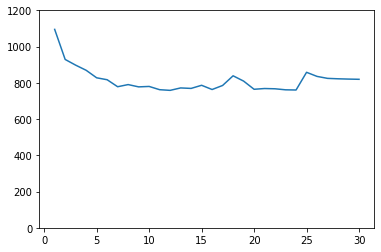

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

relevant_loss_data = args.prim_pel

loss_file = os.path.join(args.root, args.training_results, relevant_loss_data)
with open (loss_file, "r") as f:
  #a = f.readlines()
  a = np.array([i.strip() for i in f.readlines()][1:]).astype(np.float)
  a = [float(i) for i in a]

print(len(a))
l = [np.inf]
l.extend(a)
f = plt.plot(l)
plt.ylim(0, 1200)

plt.xticks(np.arange(0, 31, 5))


In [ ]:
v.load_weights(weights)

train = pickle.load( 
    open(os.path.join(input_data,"train_impl.pkl") , 'rb')
)
train_gen = datagen(train,train , args.batch_size)


batch_num = 0
item_num = 0

ins = np.array([train_gen.__getitem__(batch_num)[0][item_num]])
a = v.predict(ins)

a = -np.sort(-a)
a

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

*MOVIELENS*: 

After filtering, there are 9998816 events from 69878 users and 10196 businesses (sparsity: 1.403%)

sample prediction: [[0.43879703, 0.4058009 , 0.4028352 , ..., 0.        , 0.        ,
        0.        ]]


*YELP*:

(b only filter) After filtering, there are 8635403 events from 2189457 users and 160585 businesses (sparsity: 0.002%)

(u only filter) After filtering, there are 5766970 events from 365665 users and 159108 businesses (sparsity: 0.010%)

(full filter) After filtering, there are 5674527 events from 365664 users and 127351 businesses (sparsity: 0.012%)

sample prediction: [[0., 0., 0., ..., 0., 0., 0.]]





#Evaluation

In [ ]:
#!pip3 install tensorflow-ranking

import tensorflow_ranking as tfr

     |████████████████████████████████| 141 kB 5.6 MB/s 


In [ ]:
eval_results = os.path.join(root, "eval_results")
try:
  os.mkdir(eval_results)
except FileExistsError:
  pass

In [ ]:
test_true = pickle.load( 
    open(os.path.join(input_data,"test_impl.pkl") , 'rb')
)

test_given = pickle.load( 
    open(os.path.join(input_data,"test_testing_impl.pkl") , 'rb')
)

In [ ]:
total_num_samples = test_given.shape[0]
original_dim = test_given.shape[1]
intermediate_dim = args.intermediatedim
latent_dim = intermediate_dim//2

In [ ]:
test_gen = datagen(test_given ,test_true, args.batchsize)
test_gen.__len__()

20

In [ ]:
v = vae_builder(original_dim, intermediate_dim, latent_dim).build()
KLBeta = 1
metrics = [ tfr.keras.metrics.RecallMetric(name = "recall_20", topn=20,),
           tfr.keras.metrics.RecallMetric(name = "recall_50", topn=50,),
           tfr.keras.metrics.NDCGMetric(name = "ndcg_100", topn=100,)         
]


v.compile(optimizer='adam', loss=VAE_loss, metrics = metrics)
v.load_weights(os.path.join(training_results,"vae_secondary_train_best.hdf5"))#load best weights from secondary

In [ ]:
preds = v.evaluate(test_gen, verbose = 1)

20/20 [==============================] - 3s 106ms/step - loss: 1658.5330 - recall_20: 0.0691 - recall_50: 0.1480 - ndcg_100: 0.3272


In [ ]:
print(preds)


"""
#yelp:
0.00011902114056283608
0.0003276122151874006
0.00030501390574499965

#ml10m
0.06914284080266953, 
0.1480351686477661, 
0.32721519470214844

ml20m
0.0676
0.1382
0.3121
"""



[1658.532958984375, 0.06914284080266953, 0.1480351686477661, 0.32721519470214844]


'\n#yelp:\n0.00011902114056283608\n0.0003276122151874006\n0.00030501390574499965\n\n#ml10m\n0.06898434460163116, \n0.1480257213115692, \n0.32717984914779663\n\nml20m\n\n'